# Synthetic Quantum Electrodynamics via Generative AI
# Part IV/V -- Amortized Bayesian Posterior

$
\large
\text{Mikael Mieskolainen}
$

$
\text{Department of Physics and I-X Centre for AI in Science, Imperial College London}
$

$
\tiny
\texttt{m.mieskolainen@imperial.ac.uk}
$

<a href="https://github.com/mieskolainen">github.com/mieskolainen</a>

<br>

$
\text{May, 2025}
$

**Abstract**

In this part we do a Bayesian parameter inference with generative AI, by using *direct amortization* of the Bayesian Posterior $p(\theta \mid \mathbf{x})$. This topic is also known as Simulation Based Inference. Amortized inference offloads the heavy computation to the training stage and inference is fast. The cutting-edge developments on this field are related to e.g. parametrically post-training replaceable Bayesian priors, and gaining access to both $\mathbf{x} \sim p(\mathbf{x} \mid \theta)$ and posterior samples $\theta \sim p(\theta \mid \mathbf{x})$ from the same **unified** generative model.

<br>
<br>

**Outline:**

- [Part I: Physics Theory](tutorial_part_1.ipynb)
- [Part II: AI Theory](tutorial_part_2.ipynb)
- [Part III: Surrogate Simulator](tutorial_part_3.ipynb)
- [Part IV: Amortized Bayesian Posterior](tutorial_part_4.ipynb)
- [Part V: Deep Inverse Problems](tutorial_part_5.ipynb)

<br>

<div style="display: flex; flex-wrap: wrap; justify-content: space-between; gap: 10px;">
  <img src="img/scattering_simulation.jpeg" style="width: 49%; height: auto;">
  <img src="img/OU_simulation.jpeg" style="width: 49%; height: auto;">
</div>

> **Compatibility: Use VSCode with Jupyter extension (better LaTex rendering) or JupyterLab. Hit refresh [F5] if the notebook freezes.**


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Run this first if using Colab
"""
!git clone https://github.com/mieskolainen/AIMS25.git
%cd AIMS25
"""
import sys
sys.path.append('./xaims')

# !pip install -r requirements.txt

In [3]:
import numpy as np
import torch
import torch.optim as optim

# For reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Use device: GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    !nvidia-smi
else:
    device = torch.device("cpu")

print("Using device:", device)

Sat May 17 03:36:59 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:17:00.0 Off |                    0 |
| N/A   31C    P0    71W / 500W |   7123MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:31:00.0 Off |                    0 |
| N/A   

<br>

---
## Generate Training Data

As before, we generate training data with the QED Monte Carlo event generator.

In [4]:
from xaims import qedgen

# -------------------------------------------------------------------------------------------
total_events   = int(1e5)  # total number of events
n_sets         = int(100)  # how many simulated event sets
n_events_per_s = int(total_events / n_sets)
# -------------------------------------------------------------------------------------------

mc_events     = []
mc_conditions = []

# -------------------------------------------------------------------------------------------
# Fiducial cut of our detector (geometric acceptance)

theta_min_fiducial = np.deg2rad(5.0)    # all functions use radians
theta_max_fiducial = np.deg2rad(175.0)

for i in range(n_sets):
    
    # -------------------------------------------------------------------------------------------
    # We amortize prior here
    
    # ** Option 1: Uniform prior P(theta) **
    sqrts = np.random.uniform(1.0, 2.0) 
    
    # ** Option 2: Log-normal prior P(theta) **
    #mu, sigma, shift = -0.8181, 0.5, 1.0 # Target with mean = 1.5, X >= 1 solved parameters
    #sqrts = shift + np.random.lognormal(mean=mu, sigma=sigma, size=1)[0]
    # -------------------------------------------------------------------------------------------
    
    s     = sqrts**2
    
    # Map angular cuts to Mandelstam t
    #
    t_min = qedgen.costheta_to_t(costheta=np.cos(theta_max_fiducial), s=s)
    t_max = qedgen.costheta_to_t(costheta=np.cos(theta_min_fiducial), s=s)
    t_min = max(t_min, -(s - 4*qedgen.m_e**2)) # kinematic limit
    
    # Generate events
    x_gen, xs, xs_err, unweight_eff = \
        qedgen.generator(num_events=n_events_per_s, sqrts=sqrts, t_min=t_min, t_max=t_max, theory=qedgen.Mode.QED_bhabha)
    
    mc_events.append(x_gen)
    mc_conditions.append(np.full((n_events_per_s, 1), sqrts)) # we use sqrts scale

mc_events = np.concatenate(mc_events, axis=0)
mc_energy = np.concatenate(mc_conditions, axis=0)

# Convert training data to tensors
data_tensor  = torch.tensor(mc_events, dtype=torch.float32).to(device)
param_tensor = torch.tensor(mc_energy, dtype=torch.float32).to(device)

print("Training data: data shape = ", data_tensor.shape, "param shape = ", param_tensor.shape)


Training data: data shape =  torch.Size([100000, 3]) param shape =  torch.Size([100000, 1])


<br>

---

## Neural Network Training


### Preprocessing transforms

In [5]:
from xaims import transforms

# We will learn posterior pdf(param | data) ~ pdf(data | param) x prior(param)
#

# -------------------------------------------------------------------
# Flow space (parameter space)

# Standardization transform
zscore_map_param = transforms.ZScoreTransform(
                        param_tensor.mean(dim=0, keepdim=True),
                        param_tensor.std(dim=0, keepdim=True)).to(device)
param_norm = zscore_map_param.forward(param_tensor)

pre_transform_param = transforms.CompositeTransform([zscore_map_param]).to(device)
# -------------------------------------------------------------------

# -------------------------------------------------------------------
# Conditional space (data space)

# Physics transform
geom_map_data = transforms.PhysicsTransform(transverse_mode='pt', longitudinal_mode='pz').to(device)
data_norm     = geom_map_data.forward(data_tensor)

# Standardization transform
zscore_map_data = transforms.ZScoreTransform(data_norm.mean(dim=0, keepdim=True),
                                             data_norm.std(dim=0, keepdim=True)).to(device)
data_norm = zscore_map_data.forward(data_norm)

pre_transform_data = transforms.CompositeTransform([geom_map_data, zscore_map_data]).to(device)
# -------------------------------------------------------------------

data_dim   = data_norm.shape[-1]
param_dim  = param_norm.shape[-1]


### Train Amortized Bayesian Posterior with SDE diffusion

We learn now a SDE diffusion model for the posterior, such that we can sample $\theta \sim p(\theta \mid \mathbf{x})$, conditional on the measured event, and evaluate the posterior pdf values.


Number of model parameters: 1.9E+04


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:52<00:00,  1.32s/epoch, train_loss=0.0063, lr=0.001000, val_loss=0.0101]


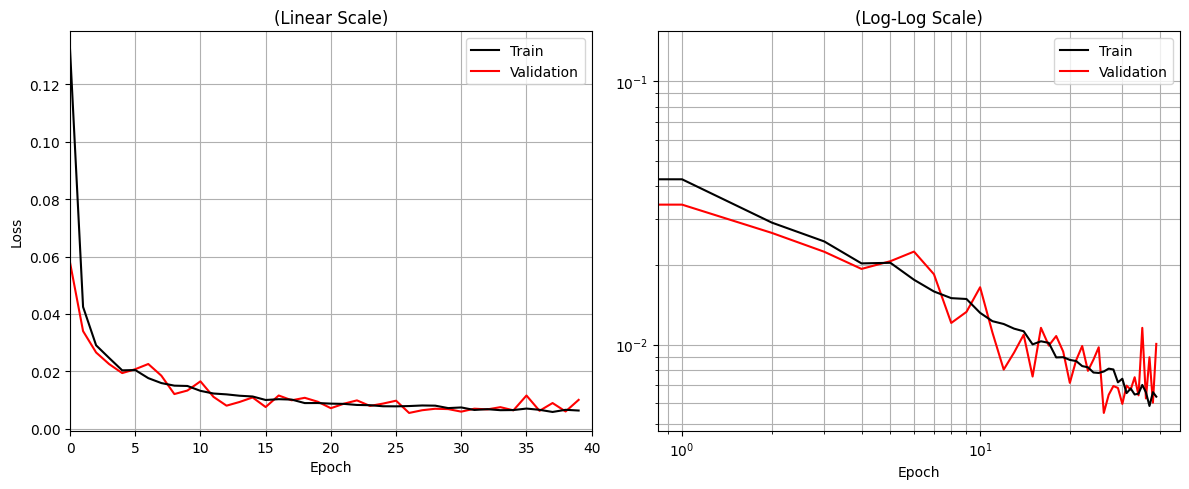

In [6]:
from xaims import sde, aux, visualize

lr           = 1e-3
weight_decay = 1e-3

n_epochs   = 40
batch_size = 256

train_loader, val_loader = aux.split_loaders(param_norm, data_norm, frac=0.8, batch_size=batch_size)

# SDE model
time_embed_dim = 8
model_sde = sde.SDEModel(
    sde      = sde.VPSDE(beta_0=0.1, beta_1=20.0), 
    x_dim    = param_dim,
    cond_dim = data_dim,
    loss_weighting = False,
    nnet     = aux.ResidualMLP(in_dim=param_dim + time_embed_dim + data_dim, out_dim=param_dim,
                           **{"hidden_dim": [128, 128], "layer_norm": True, "act": "silu", "dropout": 0}),
    time_embed_dim = time_embed_dim
).to(device)

# Optimizer and scheduler
optimizer_sde = optim.AdamW(model_sde.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_sde = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sde, 'min', factor=0.5, patience=10, min_lr=1e-5)

# Returns the best validation loss model
losses_sde, model_sde = aux.train_wrapper(model=model_sde, optimizer=optimizer_sde, scheduler=scheduler_sde,
                                  train_loader=train_loader, val_loader=val_loader, n_epochs=n_epochs)

fix,axs = visualize.plot_losses(train_losses=losses_sde[0], val_losses=losses_sde[1])


<br>

---
## Bayesian Inference

### Sampling
We apply the trained AI model to a data sample $\mathcal{D} = \{\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_N\}$. Because the events are independent and identically distributed (iid), we sample the parameter $\theta$ posterior values per event $\mathbf{x}_i$ multiple times to obtain smooth distributions, and finally concatenate all the samples. **Credibility Intervals** representing the uncertainty of our parameters are obtained by sample percentiles.

### PDF evaluation
Evaluating the posterior PDF goes as follows. We evaluate log posterior values for a finite grid of $\theta$ values on the real line, a number of $n_P$ points in total, and sum the log density values

$
\log p(\theta_k \mid \mathcal{D}) = \sum_{i=1}^N \log p(\theta_k \mid \mathbf{x}_i), \quad \forall k = 1, \dots, n_P.
$

Finally, we exponentiate to recover the posterior.


### Multiple parameters of interest

This is a typical case in practise, see more information below.

<details>
<summary><span style="color: red">Technical details (expand)</span></summary>

<br>

In many cases, the parameter is a vector $\theta = (\theta_1, \theta_2, \dots)$, representing multiple parameters of interest (either true parameters of interest, or 'nuisance'). The basic logic does not change from the 1D dimensional case above, when we are Bayesian. However, when dealing with multiple parameters, there is a key **conceptual difference** between Bayesian and Frequentist approaches.

#### Bayesian

Bayesians **marginalize** over other parameters by integrating them out of the posterior

$
p(\theta_1 \mid \mathcal{D}) = \int p(\theta_1, \theta_2, \dots \theta_N \mid \mathcal{D}) \, d\theta_2 d\theta_3 \cdots \theta_N.
$

In sample-based Bayesian methods (here, MCMC, ...), marginalization is automatic. Integration is approximated by the empirical distribution of the samples. When instead explicitly evaluating the posterior PDF, we need to manually take care of the integration.

#### Frequentist

Frequentists **profile** other parameters by optimizing (maximizing) the log-likelihood with respect to them for each value of the parameter of interest.

$
\log L_{\text{profile}}(\theta_1; \mathcal{D}) = \max_{\theta_2, \theta_3, \dots} \log L(\theta_1, \theta_2, \dots, \theta_N; \mathcal{D}),
$

which is typically done with a minimization algorithm with a negative log-likelihood. Most expensive part is typically the confidence interval construction, done by inverting a (profile) **likelihood ratio test** which allows to use the Wilks theorem $\chi^2$ asymptotics based thresholds or alternatively, by using expensive "toy Monte Carlo" and the fundamental Neyman construction. This procedure is needed because the frequentist confidence intervals are conceptually different than Bayesian credibility intervals.

#### Challenge for Frequentists

Key challenge of creating frequentist SBI methods is related to the fact that the log-likelihood **function** for a dataset is

$
\log \, L(\theta; \mathcal{D}) = \sum_{i=1} \log p(\mathbf{x}_i | \theta),
$

which treats $\theta$ as the argument by construction and data $\mathcal{D}$ as fixed. **It is not a density for $\theta$** and thus has no integral normalization over $\theta$. With $p(\mathbf{x} \mid \theta)$ learned using the generative AI model, we can only evaluate the density as a function of $\mathbf{x}$ or sample $\mathbf{x} \sim p(\mathbf{x} \mid \theta)$. The solution in essence would require **amortization of the Neyman construction**, which is the challenge.

</details>


## Generate test data

We generate a new data sample here with QED MC generator for some $\sqrt{s}$ value, which is our parameter of interest.


In [7]:
from tqdm import tqdm
from time import time

from xaims import qedgen

num_events = 1000

# Test value to be infered
# (should be within reasonable range of the prior distribution)
sqrts_test = 1.65  # GeV
s_test     = sqrts_test**2

# Compute t-limits
t_min = qedgen.costheta_to_t(costheta=np.cos(theta_max_fiducial), s=s_test)
t_max = qedgen.costheta_to_t(costheta=np.cos(theta_min_fiducial), s=s_test)
t_min = max(t_min, -(s_test - 4*qedgen.m_e**2)) # kinematic limit

tic = time()
mc_sbi, xs_tot, xs_err, unweight_eff = \
    qedgen.generator(num_events=num_events, sqrts=sqrts_test, t_min=t_min, t_max=t_max, theory=qedgen.Mode.QED_bhabha)

print(f"QED (MC): {num_events / (time() - tic) / 1000:0.1f} kHz")

# To torch tensor
test_data = torch.as_tensor(mc_sbi, dtype=torch.float32, device=device)
print(test_data.shape)


QED (MC): 97.0 kHz
torch.Size([1000, 3])


## Sampling from the posterior

We proceed now as described.

In [8]:
from xaims import aux

## Sampling wrapper
def sample_from_sde(num_samples: int, cond: torch.Tensor, steps: int=1000, use_ode: bool=False, EPS: float=None, device='cpu'):
    
    model_sde.eval() #!
    
    with torch.no_grad():
        #cond = aux.expand_dim(cond, num_samples=num_samples, device=device) # Expand batch dimensions
        cond_norm = pre_transform_data.forward(cond) # Forward processing
        
        param = model_sde.sample(num_samples, cond=cond_norm, steps=steps, use_ode=use_ode, EPS=EPS)
        samples = pre_transform_param.reverse(param) # Revert pre-processing
    
    return samples

# Posterior pdf evaluator
def logprob_sde(param: torch.Tensor, data: torch.Tensor, steps: int=1000, exact: bool=True, EPS: float=None, n_hutchinson: int=5, device='cpu'):
    
    model_sde.eval() #!
    
    with torch.no_grad():
        param         = aux.expand_dim(param, num_samples=data.shape[0], device=device) # Expand batch dimensions        
        param_norm, ldj_param = pre_transform_param.forward(param, return_logdet=True)
        data_norm     = pre_transform_data.forward(data) # Forward processing
        
        log_prob      = model_sde.log_prob(param_norm, cond=data_norm, steps=steps, exact=exact, n_hutchinson=n_hutchinson, EPS=EPS)
        log_prob     += ldj_param # Add jacobian of pre-transform
    
    return log_prob


In [9]:
## Collect posterior samples for the full dataset K times

K = 5 # Larger the better

## SDE sampler
sde_samples = []
for _ in tqdm(range(K)):
    sde_samples.append(sample_from_sde(test_data.shape[0], cond=test_data, device=device, use_ode=False))

# Concatenate
sde_samples = torch.cat(sde_samples, dim=0).cpu().numpy()

# -----------------------------------

## ODE sampler
ode_samples = []
for _ in tqdm(range(K)):
    ode_samples.append(sample_from_sde(test_data.shape[0], cond=test_data, device=device, use_ode=True))

# Concatenate
ode_samples = torch.cat(ode_samples, dim=0).cpu().numpy()


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


## Evaluating Posterior PDF

This works by using the infitesimal change of variables ODE formulation, i.e. the vector field divergence.


In [17]:
## Wrapper for intervals and point stats

def wrapper(x, alpha=5.0):
    med   = np.median(x)
    lo    = med - np.percentile(x, alpha/2)
    hi    = np.percentile(x, 100 - alpha/2) - med
    return med, lo, hi


In [18]:
## Compute log-posterior values using the probability flow divergence equation

 # Use samples to get a good parameter interval to evaluate
med, lo, hi = wrapper(ode_samples, alpha=32) # 1 sigma ~ 68CR

n_points     = 20
param_points = np.linspace(med - lo * 5, med + hi * 5, n_points)
log_prob     = np.zeros(n_points)

for i in tqdm(range(len(param_points))):
    log_prob[i] = logprob_sde(param=param_points[i], data=test_data, device=device).mean().cpu().numpy()

posterior = np.exp(log_prob)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]


## Visualize results

Now we compare different approaches.

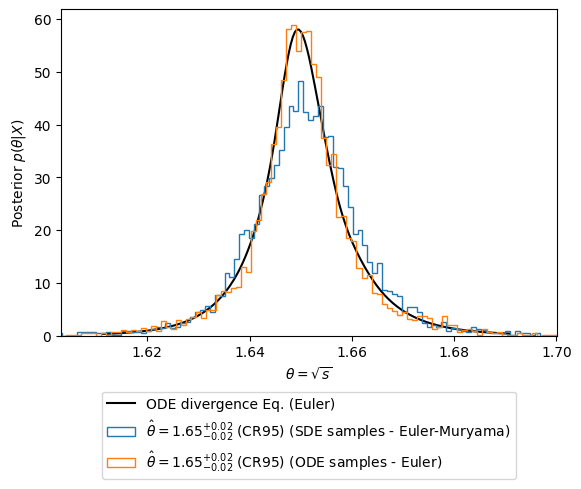

In [19]:
import scipy.interpolate
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

nbins = 100

# -------------------------------------------------
# PDF values

I = np.trapezoid(x=param_points, y=posterior)

# Create interpolation function for better results
interp_posterior = scipy.interpolate.interp1d(param_points, posterior/I, kind="cubic", 
                                             bounds_error=False, fill_value=0)

x = np.linspace(param_points[0], param_points[-1], 200)
plt.plot(x, interp_posterior(x), 'k-', label='ODE divergence Eq. (Euler)')
# -------------------------------------------------


# Set Posterior Credibility Intervals (CR68, CR95 ...) level
alpha = (1 - 0.95) * 100

# -------------------------------------------------
# SDE sampler

med, lo, hi = wrapper(sde_samples, alpha=alpha)
bins  = np.linspace(med - lo * 2, med + hi * 2, nbins)
label = f"$\\hat{{\\theta}} = {med:.2f}^{{+{hi:.2f}}}_{{-{lo:.2f}}} \\; \\mathrm{{(CR{100-alpha:0.0f})}}$ (SDE samples - Euler-Muryama)"

plt.hist(sde_samples, bins=bins, density=True, histtype='step', label=label)
plt.xlim([med - lo * 2, med + hi * 2])

# -------------------------------------------------
# ODE sampler

med, lo, hi = wrapper(ode_samples, alpha=alpha)
bins  = np.linspace(med - lo * 2, med + hi * 2, nbins)
label = f"$\\hat{{\\theta}} = {med:.2f}^{{+{hi:.2f}}}_{{-{lo:.2f}}} \\; \\mathrm{{(CR{100-alpha:0.0f})}}$ (ODE samples - Euler)"
# -------------------------------------------------

plt.hist(ode_samples, bins=bins, density=True, histtype='step', label=label)
plt.xlim([med - lo * 2, med + hi * 2])
plt.xlim([med - lo * 2, med + hi * 2])
plt.ylim([0, None])
plt.xlabel('$\\theta = \\sqrt{s}$')
plt.ylabel('Posterior $p(\\theta|X)$')
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')
plt.subplots_adjust(bottom=0.2)

plt.show()


**Note**: The posterior density seems very narrow (but perhaps with fat tails ...) because there are no detector effects included (see Notebook 5), and the parameter we want to estimate (center-of-mass energy) is actually directly linked to what we measure.

<br>

---
## ** Exercise: Bayesian evidence **

Directly amortized posterior inference does not give access to the Bayesian evidence term $p(\mathbf{x})$, without some additional effort. However, in the previous notebook we learned the data density $p(x|\theta)$, and combining both can be key. Start with the Bayes formula

$
p(\theta \mid \mathbf{x}) = \frac{p(\mathbf{x} \mid \theta) p(\theta)}{p(\mathbf{x})} = \frac{p(\mathbf{x} \mid \theta) p(\theta)}{\int p(\mathbf{x} \mid \theta) p(\theta) d\theta}.
$

**Task 1**: Write down the evidence in terms of the posterior, the data density (likelihood) and the prior, and give a generic formula for the full i.i.d dataset evidence $p(D)$ using log densities.

In [13]:
# Write here the derivation

**Task 2**: Give a reason or two why we would need the evidence, i.e. what is it good for?

In [14]:
# Write here the reasons

<br>

---
## ** Exercise: Simulator based calibration diagnostics of the posterior **

**Task 1**: Evaluate posterior calibration using simulations. Sample parameters from the prior, generate data, perform inference, and check whether the true parameter lies within the central posterior credible interval at the chosen level $(1-\alpha) \times 100 \%$. Technically, this defines a frequentist coverage test, which assesses whether credible intervals are correctly sized in a repeated sampling sense. This test complements the Simulation Based Calibration (SBC) rank statistic test which is easy to implement simultaneously, which checks whether the true parameter ranks uniformly among posterior samples. A well calibrated model should produce a uniform rank distribution spanning the full rank range. Together, these tests capture different aspects of inference quality. Compare results for both ODE and SDE sampling methods. 

| Type | Centering | Dispersion | SBC Rank Histogram Shape                 | Coverage Test |
|------|-----------|------------|------------------------------------------|-------------------|
|  I   | Unbiased  | Correct    | **Flat uniform** (within full rank range) | Nominal       |
| II   | Unbiased  | Too narrow | **U-shaped** (excess counts at the two ends)  | Undercoverage |
| III  | Unbiased  | Too wide   | **Peaked at centre** (excess mid-ranks)       | Overcoverage  |
| IV   | Biased    | Correct    | **Skewed**       | Undercoverage |
|  V   | Biased    | Too narrow | **Skewed + U-shaped**      | Undercoverage |
| VI   | Biased    | Too wide   | **Skewed + peaked at centre**   | Overcoverage  |

The table above gives expected results for different scenarios, although more complicated cases exist e.g. with multimodal posteriors.

**SBC rank test**: <a href="https://arxiv.org/abs/1804.06788">Talts et al., *Validating Bayesian Inference Algorithms with Simulation-Based Calibration*, [arXiv: 1804.06788]</a>

**Information:** In order to gain systematic understanding of the impact of the AI model and training parameters, and prior densities $p(\theta)$, one needs to train models with different setups and evaluate each separately. During evaluation, no model training is involved and same priors are used. Additionally, it may be necessary to introduce resolution effects into the (otherwise perfect) data simulations during both training and evaluation (see Notebook 5), because our parameter of interest $\theta = \sqrt{s}$ is a direct kinematic function of the observed event kinematics due to energy–momentum conservation.


In [15]:
# Implement full code here.

<br>

---
## Check your knowledge

1. **What is meant by direct amortization?**
2. **How would you implement purely Frequentist parameter inference, i.e. maximum likelihood and confidence intervals?**
3. **With SDE diffusion models, why is the sample based approach to the posterior more scalable than using the SDE-ODE probability flow evaluation approach?**
4. **In higher parameter $\theta$-space dimensions, is the sampling actually only feasible approach, cf. Bayesian vs Frequentist?**
6. **How do you check the posterior (coverage) is actually properly calibrated, i.e. meaningful?**
